In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

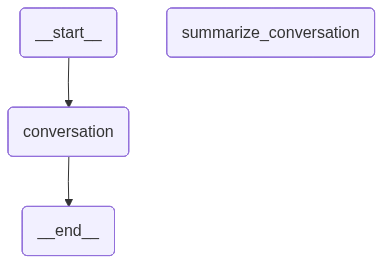

In [2]:
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4.1-mini", temperature=0) 

class State(MessagesState):
    summary: str

def call_model(state: State, config: RunnableConfig):
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def should_continue(state: State):
    """Return the next node to execute."""
    
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"

    return END

workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
config = {"configurable": {"thread_id": "1"}}

for chunk in graph.stream({"messages": [HumanMessage(content="Hi! I'm Daksh")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hi Daksh! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 12, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'id': 'chatcmpl-CVHO7hp98Y5ES6BtPlbHE6XcKmn4i', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--937b1a70-db90-42e1-966d-42e4807bc690-0', usage_metadata={'input_tokens': 12, 'output_tokens': 11, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [4]:
for chunk in graph.stream({"messages": [HumanMessage(content="Hi! I'm Daksh")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hello again, Daksh! How can I help you today?


In [5]:
config = {"configurable": {"thread_id": "2"}}

input_message = HumanMessage(content="Hi! I'm Daksh")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

Hi! I'm Daksh
---------------------------------------------------------------------------
================================ Human Message =================================

Hi! I'm Daksh
================================== Ai Message ==================================

Hi Daksh! How can I assist you today?
---------------------------------------------------------------------------


In [6]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 2015 FC Barcelona team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

In [7]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 2015 FC Barcelona team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--cdf925b4-c7ee-4756-9312-0bebb1d9a814')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--cdf925b4-c7ee-4756-9312-0bebb1d9a814')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run--cdf925b4-c7ee-4756-9312-0bebb1d9a814')}
{'chunk': AIMessageChunk(content='201', additional_kwargs={}, response_metadata={}, id='run--cdf925b4-c7ee-4756-9312-0bebb1d9a814')}
{'chunk': AIMessageChunk(content='5', additional_kwargs={}, response_metadata={}, id='run--cdf925b4-c7ee-4756-9312-0bebb1d9a814')}
{'chunk': AIMessageChunk(content=' FC', additional_kwargs={}, response_metadata={}, id='run--cdf925b4-c7ee-4756-9312-0bebb1d9a814')}
{'chunk': AIMessageChunk(content=' Barcelona', additional_kwargs={}, response_metadata={}, id='run--cdf925b4-c7ee-4756-9312-0bebb1d9a814')}
{'chunk': AIMessageChunk(content=' team', additional_kwargs={}, respo

In [8]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 2015 FC Barcelona team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| |201|5| FC| Barcelona| team| is| widely| regarded| as| one| of| the| greatest| football| squads| in| history|.| Under| the| management| of| Luis| Enrique|,| the| team| achieved| remarkable| success| during| the| |201|4|-|201|5| season|,| showcasing| a| blend| of| tactical| innovation|,| individual| brilliance|,| and| cohesive| teamwork|.

|###| Key| Ach|ievements|
|-| **|Tre|ble| Winners|:**| Barcelona| won| the| tre|ble|,| securing| three| major| trophies| in| a| single| season|:
| | -| **|La| Liga|:**| They| finished| first| in| the| Spanish| league|.
| | -| **|C|opa| del| Rey|:**| They| won| the| Spanish| domestic| cup|.
| | -| **|UE|FA| Champions| League|:**| They| tri|ump|hed| in| Europe|’s| premier| club| competition|,| defeating| Juventus| |3|-|1| in| the| final|.

|###| Playing| Style|
|-| The| team| combined| the| traditional| Barcelona| possession|-based| style| (|t|iki|-t|aka|)| with| a| more| direct| and| dynamic| approach|.
|-| They| were| known| for| quick| passing|

In [12]:
from langgraph_sdk import get_client

URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

assistants = await client.assistants.search()

In [ ]:
thread = await client.threads.create()
input_message = HumanMessage(content="Divide 63 by 7")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '019a25dc-842e-750e-9e30-18ce26c9046f', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Divide 63 by 7', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'afa56319-81d4-45a8-96ed-0c16d0f25bb5', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Divide 63 by 7', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'afa56319-81d4-45a8-96ed-0c16d0f25bb5', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_CILimYHWgraf3PuT3SnlfaUk', 'function': {'arguments': '{"a":63,"b":7}', 'name': 'divide'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_token

In [14]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="Divide 63 by 7")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    
    print('='*25)

content='Divide 63 by 7' additional_kwargs={} response_metadata={} id='23b8dcd2-b47e-4bb3-9ed3-b97bb82ff3e5'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_pobGMl23XaWnfxdNWCcF3YEH', 'function': {'arguments': '{"a":63,"b":7}', 'name': 'divide'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVHbW9XGb0jZXEDb9tjPGrup9xUps', 'service_tier': 'default', 'finish_reason': 'tool_calls'

In [15]:
thread = await client.threads.create()
input_message = HumanMessage(content="Divide 63 by 7")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


In [16]:
thread = await client.threads.create()
input_message = HumanMessage(content="Divide 63 by 7")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.
    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.
    """

    if tool_calls:
        formatted_calls = []
        
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        
        return "\n".join(formatted_calls)
    
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    elif event.event == "messages/partial":
        for data_item in event.data:
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")
                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))
                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))
                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 019a25e2-80b0-741a-bf0e-e8cdf632abd7
--------------------------------------------------
Tool Calls:
Tool Call ID: call_xX3HRiPWuN39HBDNsvJGmNlI, Function: divide, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_xX3HRiPWuN39HBDNsvJGmNlI, Function: divide, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_xX3HRiPWuN39HBDNsvJGmNlI, Function: divide, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_xX3HRiPWuN39HBDNsvJGmNlI, Function: divide, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_xX3HRiPWuN39HBDNsvJGmNlI, Function: divide, Arguments: {'a': 63}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_xX3HRiPWuN39HBDNsvJGmNlI, Function: divide, Arguments: {'a': 63}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_xX3HRiPW

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage, AIMessage
config = {"configurable": {"thread_id": "6"}}

long_input = [
    HumanMessage(content="Hi! I'm Daksh"),
    AIMessage(content="Hello how may i help you"),
    HumanMessage(content="When was Lionel Messi born?"),
    AIMessage(content="Lionel Andrés Messi was born on June 24, 1987, in Rosario, Argentina."),
    HumanMessage(content="Who did I ask you about?"),
    AIMessage(content="You asked me about Lionel Messi."),
    HumanMessage(content="What is his nationality?"),
]
print("Streaming summary tokens for summarization_nodes:")

async for event in graph.astream_events({"messages": long_input}, 
                                        config, 
                                        version="v2"):
    if (event["event"] == "on_chat_model_stream" and 
        event['metadata'].get('langgraph_node','') == "summarize_conversation"):
        data = event["data"]
        print(data["chunk"].content, end="|")

Streaming summary tokens for summarization_nodes:
|Sure|!| Here's| a| summary| of| our| conversation|:

|-| You| introduced| yourself| as| Dak|sh|.
|-| You| asked| about| Lionel| Messi|'s| birth|date|.
|-| I| informed| you| that| Lionel| Messi| was| born| on| June| |24|,| |198|7|.
|-| You| asked| who| you| had| in|quired| about|,| and| I| confirmed| it| was| Lionel| Messi|.
|-| You| then| asked| about| his| nationality|,| and| I| replied| that| he| is| Argentine|.|||